## Visualize the model
* https://github.com/keplr-io/quiver
* https://transcranial.github.io/keras-js


## Show output (*activations*) of specific layer

In [1]:
from keras.models import load_model,Model
import dogs_vs_cats as dvc
import numpy as np

modelname = "cnn_model_trained.h5"
cnn_model = load_model(modelname)


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN 5105)


In [2]:
# Load some data
from keras.applications.imagenet_utils import preprocess_input
all_files = dvc.image_files()
all_files = np.array(all_files)
files_ten = all_files[np.random.choice(len(all_files),10)]
ten_img_features,ten_img_labels = dvc.load_image_set(files_ten,(3,50,50))
ten_img_features = preprocess_input(ten_img_features)

data file train.zip has already been downloaded
Data has already been extracted
loading image (1/10)


In [3]:
# Test network work as good as before
results = cnn_model.evaluate(ten_img_features,ten_img_labels)
print(" ".join(["%s: %.4f"%(metric_name,valor) for metric_name,valor in zip(cnn_model.metrics_names,results)]))

10/10 [==============================] - 0s
loss: 1.6871 acc: 0.7000


In [4]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
model_maxpooling1 = Model(input=cnn_model.input,
                          output=cnn_model.get_layer("maxpooling2d_1").output)
print(model_maxpooling1.input_shape,
      model_maxpooling1.output_shape)

(None, 3, 50, 50) (None, 32, 23, 23)


In [5]:
feat_max_pooling = model_maxpooling1.predict(ten_img_features)
feat_max_pooling.shape

(10, 32, 23, 23)

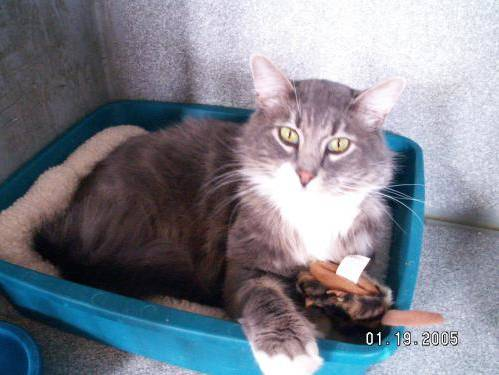

In [6]:
from IPython.display import Image, display
img_show = 3
display(Image(files_ten[img_show]))

<IPython.core.display.Javascript object>


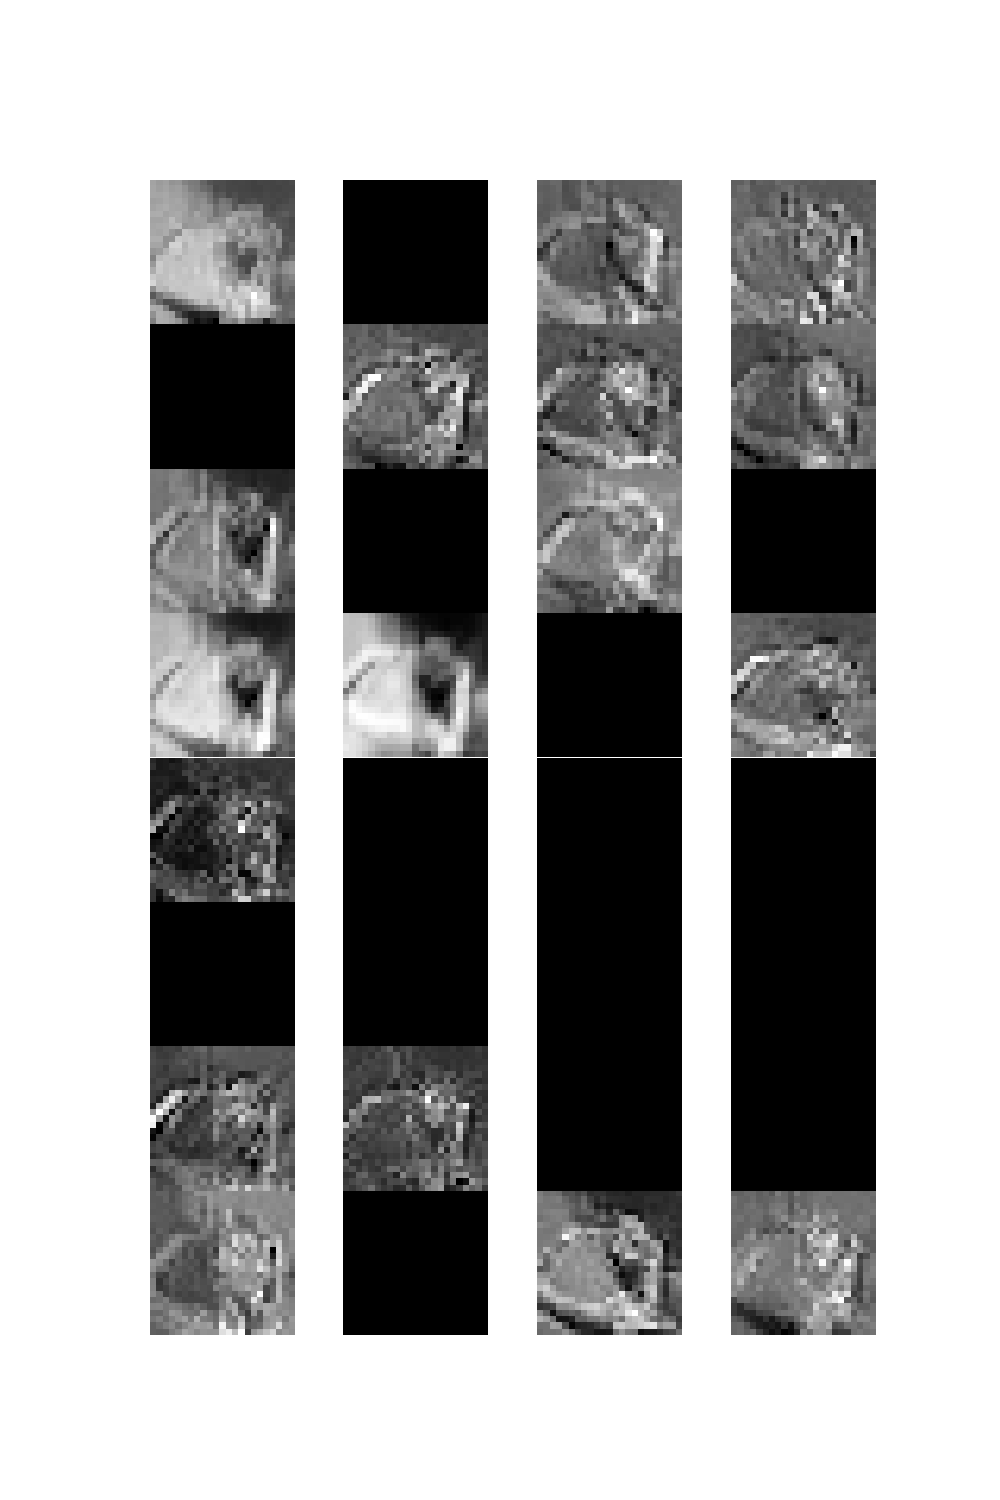

In [7]:
import matplotlib.pyplot as plt
%matplotlib notebook


fig, axs = plt.subplots(8,4,figsize=(10,15),sharex=True,sharey=True)
axs = axs.flatten()
feat_show = feat_max_pooling[img_show]
for ax,feats in zip(axs,feat_show):
    ax.imshow(feats,cmap="gray")
    ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)

## Show convolutional filters

In [8]:
W,b = cnn_model.get_layer("convolution2d_1").get_weights()
W.shape,b.shape

((32, 3, 3, 3), (32,))

<IPython.core.display.Javascript object>


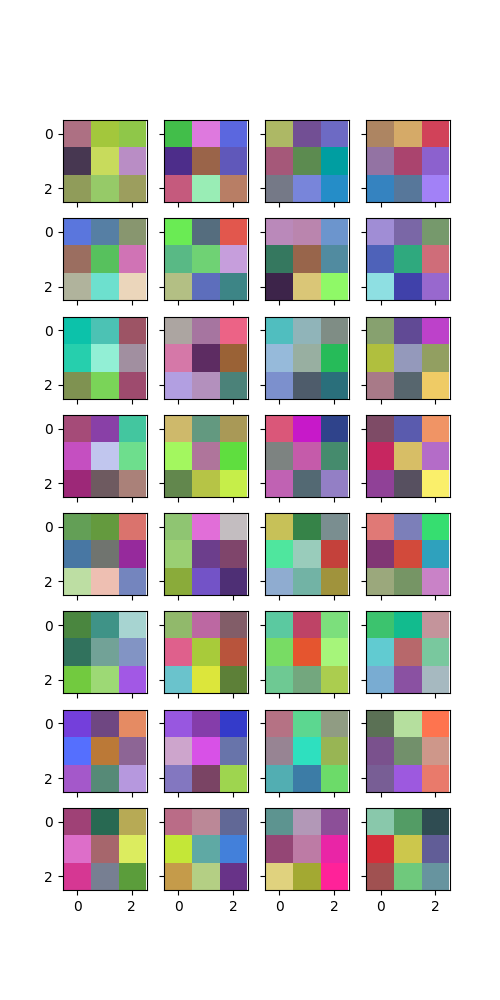

In [9]:
W_show = (W-W.min())/(W.max()-W.min())
%matplotlib notebook

fig, axs = plt.subplots(8,4,figsize=(5,10),sharex=True,sharey=True)
axs = axs.flatten()
for ax,w in zip(axs,W_show):
    ax.imshow(w)

In [10]:
from keras.applications.vgg16 import VGG16
import numpy as np

# https://keras.io/applications/#vgg16
vgg16_model = VGG16(weights='imagenet')
W,b = vgg16_model.get_layer("block1_conv1").get_weights()
W.shape,b.shape

ValueError: DeepCopyOp: the copy failed!
Apply node that caused the error: DeepCopyOp(block5_conv3_W)
Toposort index: 0
Inputs types: [CudaNdarrayType(float32, 4D)]
Inputs shapes: [(512, 512, 3, 3)]
Inputs strides: [(4608, 9, 3, 1)]
Inputs values: ['not shown']
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

<IPython.core.display.Javascript object>


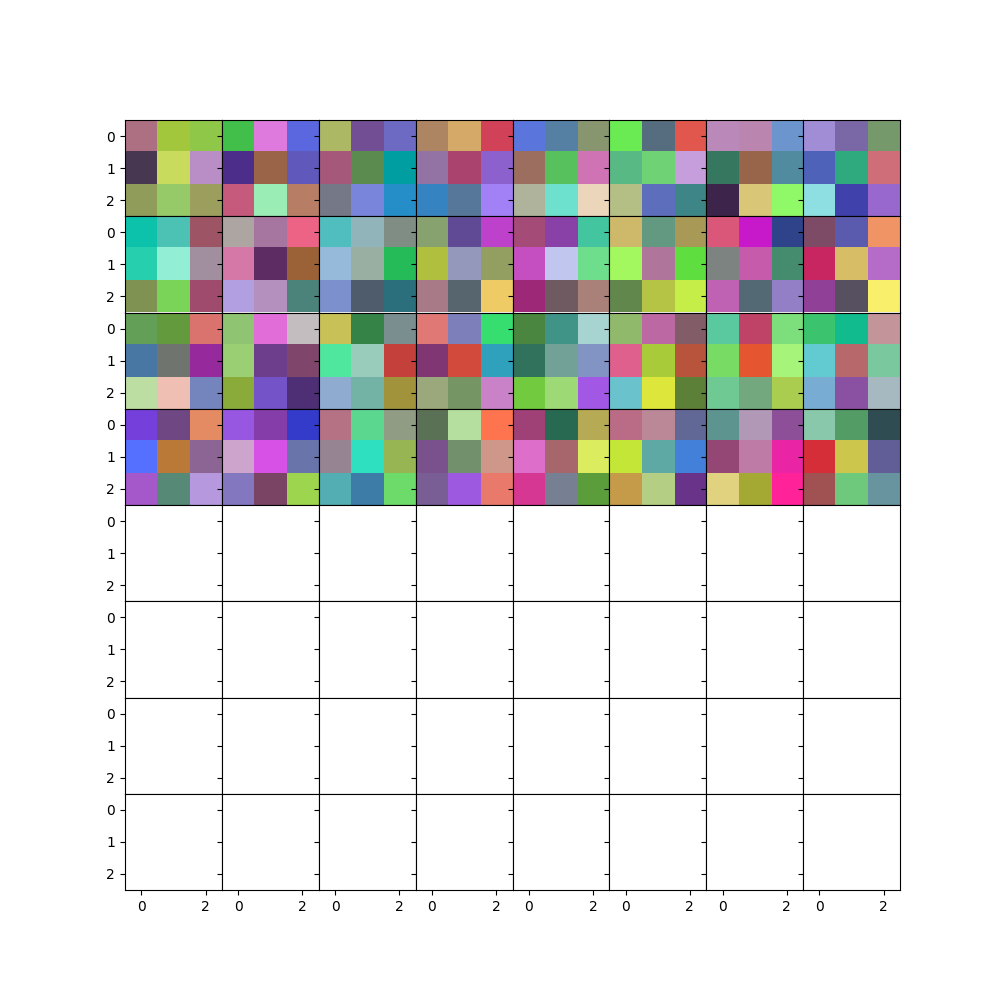

In [12]:
%matplotlib notebook

W_show = (W-W.min())/(W.max()-W.min())
fig, axs = plt.subplots(8,8,figsize=(10,10),sharex=True,sharey=True)
axs = axs.flatten()
for ax,w in zip(axs,W_show):
    ax.imshow(w)
plt.subplots_adjust(wspace=0, hspace=0)

## Show activations with `quiver`


Install quiver: 
```
pip install --no-deps git+git://github.com/jakebian/quiver.git
```

In [ ]:
import os
import shutil

# copy some images in other dir to avoid saturate quiqver:
dirname = "trains_subset"
if not os.path.exists(dirname):
    os.mkdir(dirname)
    all_files = dvc.image_files()
    for img in all_files[np.random.choice(len(all_files),15)]:
        shutil.copy(img,
                    os.path.join(dirname,os.path.basename(img)))


In [ ]:
import quiver_engine.server as server
server.launch(cnn_model,classes=["dog","cat"],input_folder=dirname)

In [ ]:
!ls